# Modelo Original Propuesto

A continuación serealizará un modelo de ensamblado especialmente diseñado para el problema de riesgo crediticio con fuerte desbalance (8 % de positivos).

El flujo de trabajo paso a paso incluye:

1. Preprocesamiento (imputación, escalado, codificación).

2. Técnicas de balanceo (SMOTE, ADASYN, BorderlineSMOTE, SMOTEENN, SMOTETomek, RandomUnderSampler, class_weight).

3. Selección de estimadores base (RandomForest, XGBoost, LogisticRegression).

4. GridSearchCV amplio con validación cruzada estratificada.

5. Ensamble por apilamiento (StackingClassifier) con meta-estimador.

6. Evaluación básica (matriz de confusión, classification report, AUC-ROC, PR curve).

7. Evaluación avanzada (curva de calibración, lift chart, KS statistic, feature importance/SHAP).




# Sección 1: Configuración Inicial y Preparación de Datos

## 1. Carga y división de datos

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Carga
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\jbook_Proyecto_Final_Clasificacion\docs2\credit_prueba.csv")
X = df.drop("incumplimiento_credito", axis=1)
y = df["incumplimiento_credito"]

# 2. División
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 2. Preprocesamiento

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Detectar columnas
num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


## 3. Definición de técnicas de balanceo

In [3]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

sampler_dict = {
    "SMOTE":        SMOTE(random_state=42),
    "ADASYN":       ADASYN(random_state=42),
    "Borderline":   BorderlineSMOTE(random_state=42),
    "SMOTEENN":     SMOTEENN(random_state=42),
    "SMOTETomek":   SMOTETomek(random_state=42),
    "UnderSampler": RandomUnderSampler(random_state=42),
}

samplers = list(sampler_dict.values())


## 4. Estimadores base

Se probarán tres familias de modelos:

* RandomForestClassifier (con class_weight='balanced').

* XGBClassifier (con scale_pos_weight ajustado).

* LogisticRegression (con class_weight='balanced').

In [4]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

estimators = {
    "RF": RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
    "XGB": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    "LR": LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")
}

# Sección 2: Fase de Modelado

## 1. Grid para RandomForest

In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

pipeline_rf = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", samplers[0]),  # placeholder, se selecciona en la grilla
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    "sampler": samplers,
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5]
}

# Definir el esquema de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Medir tiempo de entrenamiento después de definir grid_rf
t0 = time.time()
grid_rf.fit(X_train, y_train)
t_rf = time.time() - t0

# Mostrar visualmente el mejor estimador
grid_rf.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tipo_contrato', 'genero', 'posee_auto', 'posee_vivienda',
       'ingreso_total', 'cuota_periodica', 'poblacion_relativa_region',
       'dias_desde_nacimiento', 'dias_desde_registro', 'dias_desde_emision_id'...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['numero_hijos', 'acompanantes_solicitud', 'tipo_ingreso',
       'nivel_educativo', 'estado_civil', 'tipo_vivienda', 'ocupacion',
       'dia_solicitud', 'hora_solicitud', 'tipo_organizacion'],
      dtype='object'))])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('clf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

## 2.Grid para XGBoost

In [6]:
from xgboost                   import XGBClassifier
import time

pipeline_xgb = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", samplers[0]),
    ("clf", XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

param_grid_xgb = {
    "sampler": samplers,
    "clf__n_estimators":     [100, 200],
    "clf__max_depth":        [3, 5, 7],
    "clf__learning_rate":    [0.05, 0.1],
    "clf__scale_pos_weight": [1, 5, 10]
}

# Definir el esquema de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Medir tiempo de entrenamiento después de definir grid_rf
t0 = time.time()
grid_xgb.fit(X_train, y_train)
t_xgb = time.time() - t0

from sklearn import set_config
set_config(display='diagram')  # Activa el modo de diagrama

# Mostrar visualmente el mejor estimador
grid_xgb.best_estimator_


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenDa

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tipo_contrato', 'genero', 'posee_auto', 'posee_vivienda',
       'ingreso_total', 'cuota_periodica', 'poblacion_relativa_region',
       'dias_desde_nacimiento', 'dias_desde_registro', 'dias_desde_emision_id'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## 3.Grid para LogisticRegression

In [7]:
from sklearn.linear_model     import LogisticRegression
import time

pipeline_lr = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", samplers[0]),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

param_grid_lr = {
    "sampler": samplers,
    "clf__C":       [0.001, 0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

# Definir el esquema de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

t0 = time.time()
grid_lr.fit(X_train, y_train)
t_lr = time.time() - t0

# Mostrar visualmente el mejor estimador
grid_lr.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tipo_contrato', 'genero', 'posee_auto', 'posee_vivienda',
       'ingreso_total', 'cuota_periodica', 'poblacion_relativa_region',
       'dias_desde_nacimiento', 'dias_desde_registro', 'dias_desde_emision_id'...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['numero_hijos', 'acompanantes_solicitud', 'tipo_ingreso',
       'nivel_educativo', 'estado_civil', 'tipo_vivienda', 'ocupacion',
       'dia_solicitud', 'hora_solicitud', 'tipo_organizacion'],
      dtype='object'))])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000, solver='liblinear'))])

## 4.Recuperar los mejores estimadores

In [8]:
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_lr = grid_lr.best_estimator_


## 5.Ensamble por apilamiento (Stacking)

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Definir el modelo de stacking
stack = StackingClassifier(
    estimators=[
        ("RF", best_rf),   # ya incluye preproc + sampler
        ("XGB", best_xgb),
        ("LR", best_lr),
    ],
    final_estimator=LogisticRegression(class_weight="balanced", random_state=42),
    cv=cv,
    n_jobs=-1,
    passthrough=False
)

# Medir tiempo de entrenamiento (después de definir `stack`)
import time
t0 = time.time()
stack.fit(X_train, y_train)
t_stack = time.time() - t0

# Sección 3: Evaluación Básica del Modelo

## 1.Metricas de Desempeño Comparativas

In [10]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import pandas as pd

# Modelos + tiempos
models = {
    "RF":    best_rf,
    "XGB":   best_xgb,
    "LR":    best_lr,
    "STACK": stack if "stack" in globals() else stack_pipeline
}

opt_times = {
    "RF":    t_rf,
    "XGB":   t_xgb,
    "LR":    t_lr,
    "STACK": t_stack
}

records = []
for name, mdl in models.items():
    y_pred  = mdl.predict(X_test)
    y_proba = mdl.predict_proba(X_test)[:,1]

    records.append({
        "Modelo":             name,
        "Precision":          precision_score(y_test, y_pred, zero_division=0),
        "Recall":             recall_score(y_test, y_pred, zero_division=0),
        "F1-score":           f1_score(y_test, y_pred, zero_division=0),
        "AUC-ROC":            roc_auc_score(y_test, y_proba),
        "Avg Precision":      average_precision_score(y_test, y_proba),
        "Tiempo Optimización (s)": round(opt_times[name], 1)
    })

df_metrics = pd.DataFrame(records).set_index("Modelo").round(4)
df_metrics["Rank Recall"] = df_metrics["Recall"].rank(ascending=False).astype(int)

best_model = df_metrics["Recall"].idxmax()

# Mostrar con estilo
display(
    df_metrics.style
      .background_gradient(subset=["Recall","AUC-ROC","Avg Precision"], cmap="Blues")
      .highlight_max("Recall", color="salmon")
      .set_caption("Comparativa de métricas y tiempos de optimización")
)
print(f"➡️ Mejor modelo por Recall: {best_model}")


,Precision,Recall,F1-score,AUC-ROC,Avg Precision,Tiempo Optimización (s),Rank Recall
Modelo,,,,,,,
RF,0.133300,0.444400,0.205100,0.608700,0.212300,15.500000,4
XGB,0.176500,0.666700,0.279100,0.763100,0.495400,12.100000,1
LR,0.128200,0.555600,0.208300,0.573900,0.141800,0.300000,3
STACK,0.193500,0.666700,0.300000,0.739900,0.455600,1.600000,1


➡️ Mejor modelo por Recall: XGB


## 2.Evaluación Visual

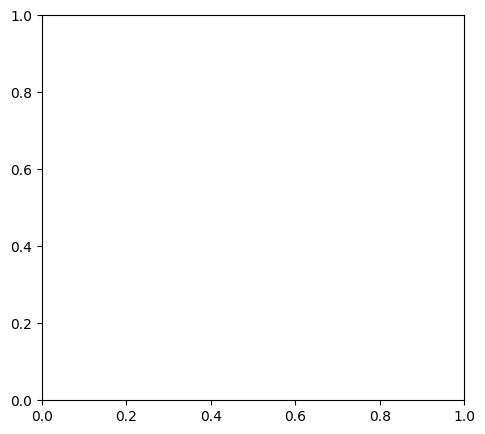

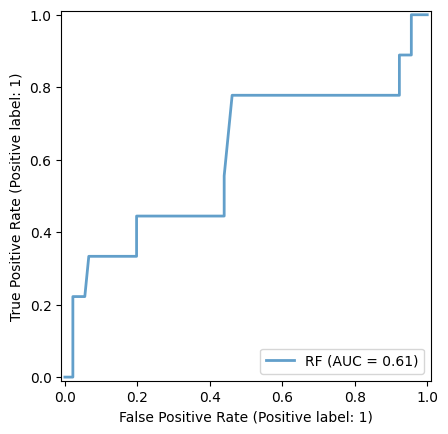

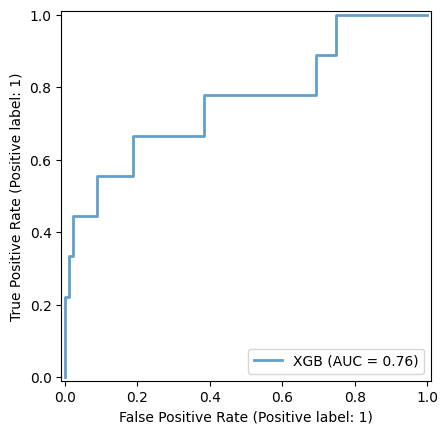

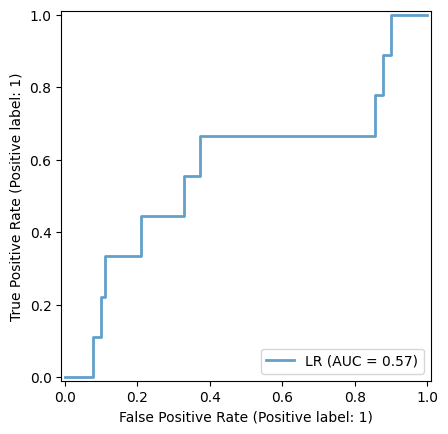

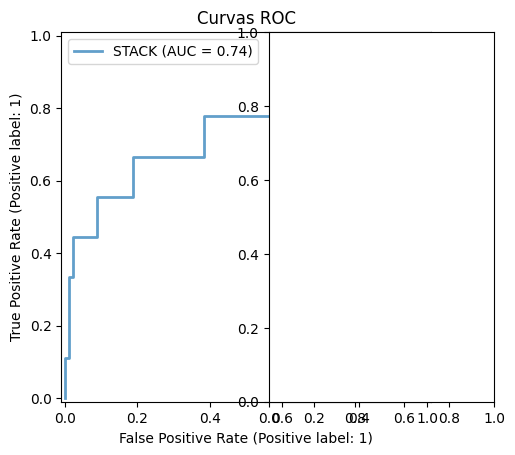

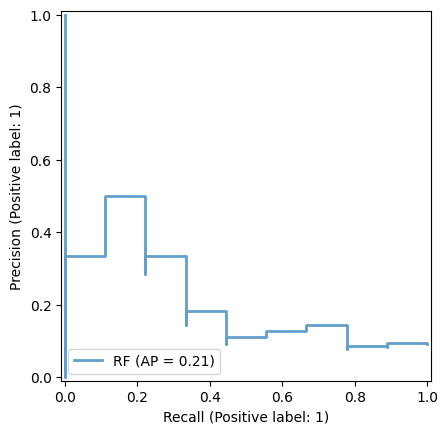

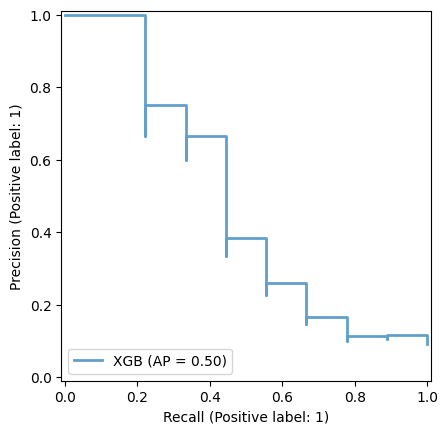

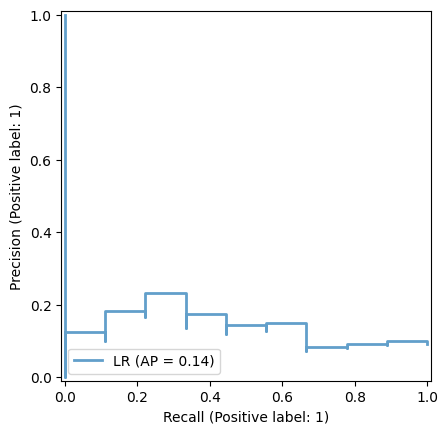

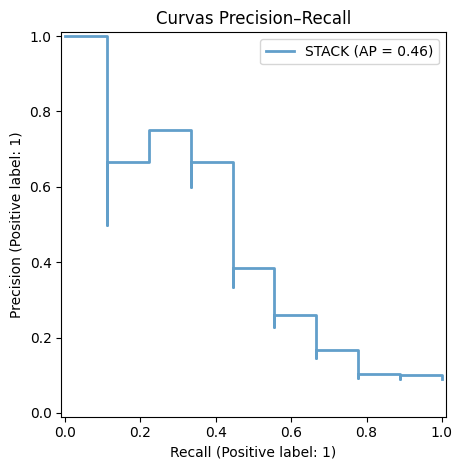

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    RocCurveDisplay, PrecisionRecallDisplay
)

# 9.1 Curvas ROC y PR de todos
plt.figure(figsize=(12,5))

# ROC
plt.subplot(1,2,1)
for name, mdl in models.items():
    y_proba = mdl.predict_proba(X_test)[:,1]
    disp = RocCurveDisplay.from_predictions(y_test, y_proba, name=name, alpha=0.7, lw=2)
plt.title("Curvas ROC")
plt.legend()

# Precision–Recall
plt.subplot(1,2,2)
for name, mdl in models.items():
    y_proba = mdl.predict_proba(X_test)[:,1]
    disp = PrecisionRecallDisplay.from_predictions(y_test, y_proba, name=name, alpha=0.7, lw=2)
plt.title("Curvas Precision–Recall")
plt.legend()

plt.tight_layout()
plt.show()


## 3.Gráficos específicos del Mejor Modelo (por Recall)

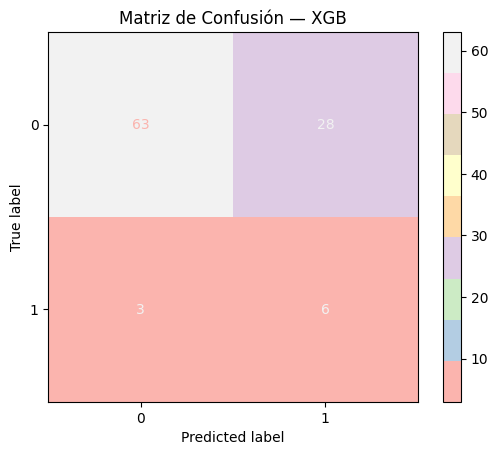

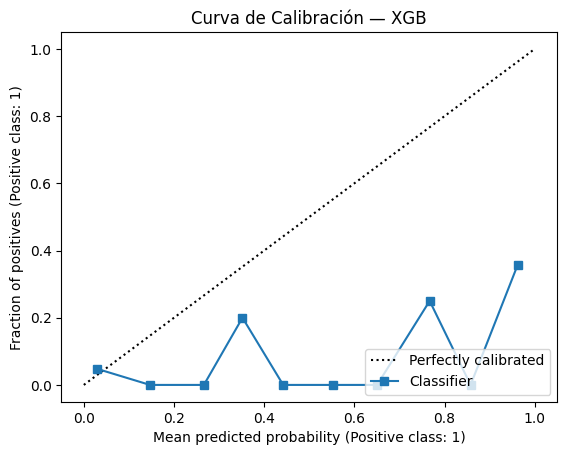

In [12]:
# Usamos best_model para extraer sus predicciones
mdl_best = models[best_model]
y_pred_b = mdl_best.predict(X_test)
y_proba_b = mdl_best.predict_proba(X_test)[:,1]

# 10.1 Matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_b, cmap="Pastel1")
plt.title(f"Matriz de Confusión — {best_model}")
plt.show()

# 10.2 Curva de calibración
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_predictions(y_test, y_proba_b, n_bins=10)
plt.title(f"Curva de Calibración — {best_model}")
plt.show()


# Sección 4: Evaluación Avanzada del Modelo

## 1.Curva de calibración

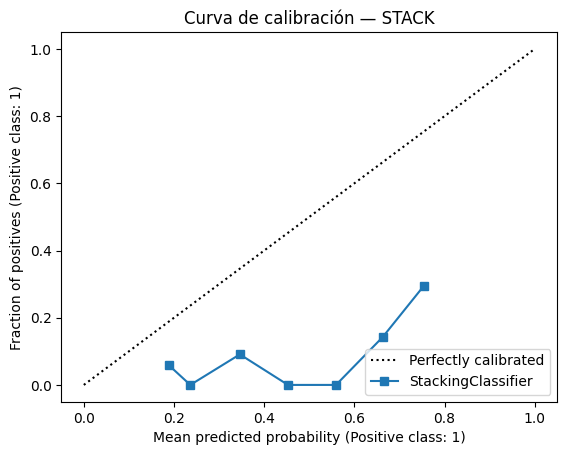

In [13]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
CalibrationDisplay.from_estimator(stack, X_test, y_test, n_bins=10)
plt.title("Curva de calibración — STACK")
plt.show()


## 2.Lift Chart / Cumulative Gain

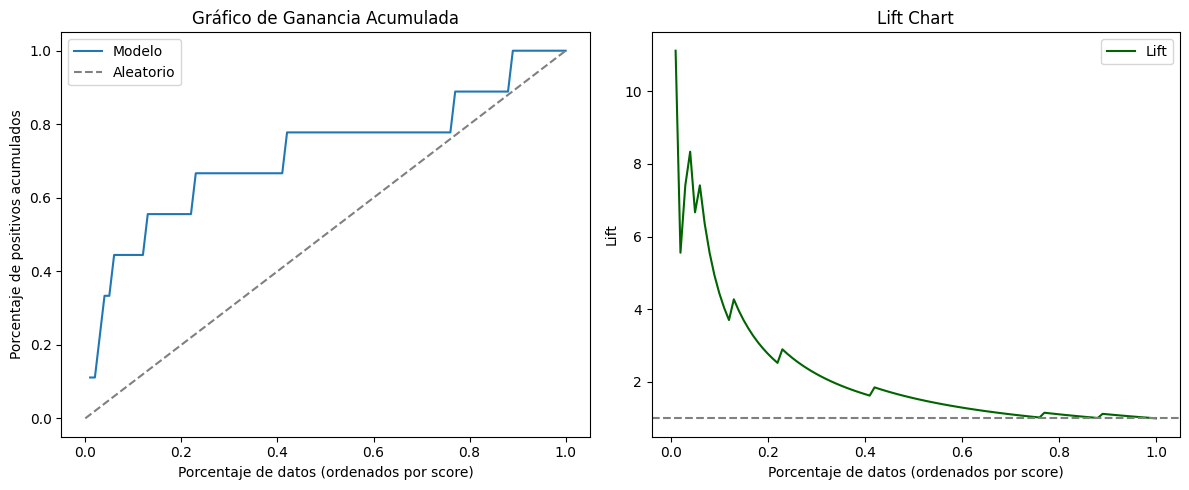

In [14]:

import matplotlib.pyplot as plt
import numpy as np

# Crear dataframe ordenado por score descendente
proba_df = pd.DataFrame({"y": y_test, "score": y_proba})
proba_df = proba_df.sort_values("score", ascending=False).reset_index(drop=True)

# Calcular columnas auxiliares
proba_df["positivos_acumulados"] = proba_df["y"].cumsum()
total_positivos = proba_df["y"].sum()
proba_df["porcentaje_positivos_acumulados"] = proba_df["positivos_acumulados"] / total_positivos
proba_df["porcentaje_datos"] = (np.arange(1, len(proba_df) + 1)) / len(proba_df)
proba_df["lift"] = proba_df["porcentaje_positivos_acumulados"] / proba_df["porcentaje_datos"]

# Gráfico: Cumulative Gain
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(proba_df["porcentaje_datos"], proba_df["porcentaje_positivos_acumulados"], label="Modelo")
plt.plot([0, 1], [0, 1], '--', label="Aleatorio", color="gray")
plt.xlabel("Porcentaje de datos (ordenados por score)")
plt.ylabel("Porcentaje de positivos acumulados")
plt.title("Gráfico de Ganancia Acumulada")
plt.legend()

# Gráfico: Lift
plt.subplot(1, 2, 2)
plt.plot(proba_df["porcentaje_datos"], proba_df["lift"], label="Lift", color="darkgreen")
plt.axhline(y=1, linestyle="--", color="gray")
plt.xlabel("Porcentaje de datos (ordenados por score)")
plt.ylabel("Lift")
plt.title("Lift Chart")
plt.legend()

plt.tight_layout()
plt.show()


## 3.KS Statistic

In [15]:
from scipy.stats import ks_2samp
pos = y_proba[y_test==1]
neg = y_proba[y_test==0]
ks_stat, _ = ks_2samp(pos, neg)
print("KS:", ks_stat)


KS: 0.47985347985347987


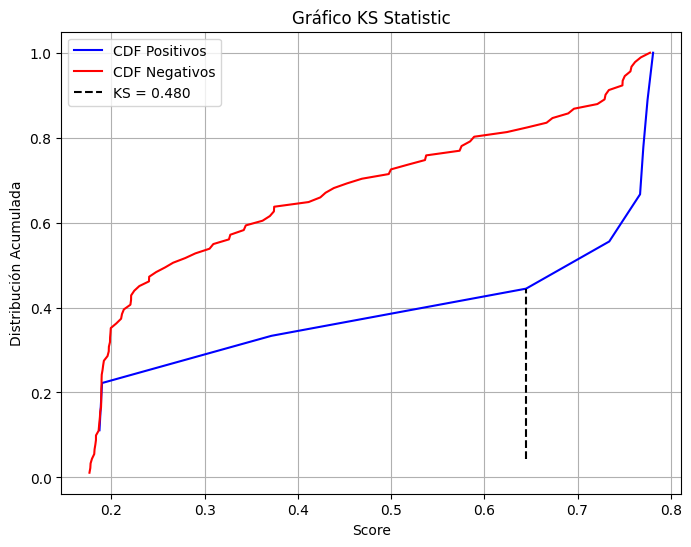

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp

# Scores
pos = y_proba[y_test == 1]
neg = y_proba[y_test == 0]

# CDFs
pos_sorted = np.sort(pos)
neg_sorted = np.sort(neg)
cdf_pos = np.arange(1, len(pos_sorted)+1) / len(pos_sorted)
cdf_neg = np.arange(1, len(neg_sorted)+1) / len(neg_sorted)

# Calcular KS statistic
ks_stat, _ = ks_2samp(pos, neg)
ks_position = np.argmax(np.abs(np.interp(pos_sorted, neg_sorted, cdf_neg) - cdf_pos))

# Plot KS
plt.figure(figsize=(8, 6))
plt.plot(pos_sorted, cdf_pos, label="CDF Positivos", color="blue")
plt.plot(neg_sorted, cdf_neg, label="CDF Negativos", color="red")
plt.vlines(pos_sorted[ks_position], cdf_neg[ks_position], cdf_pos[ks_position], color="black", linestyle="--", label=f"KS = {ks_stat:.3f}")
plt.xlabel("Score")
plt.ylabel("Distribución Acumulada")
plt.title("Gráfico KS Statistic")
plt.legend()
plt.grid(True)
plt.show()


## 4.Feature importance y SHAP

c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


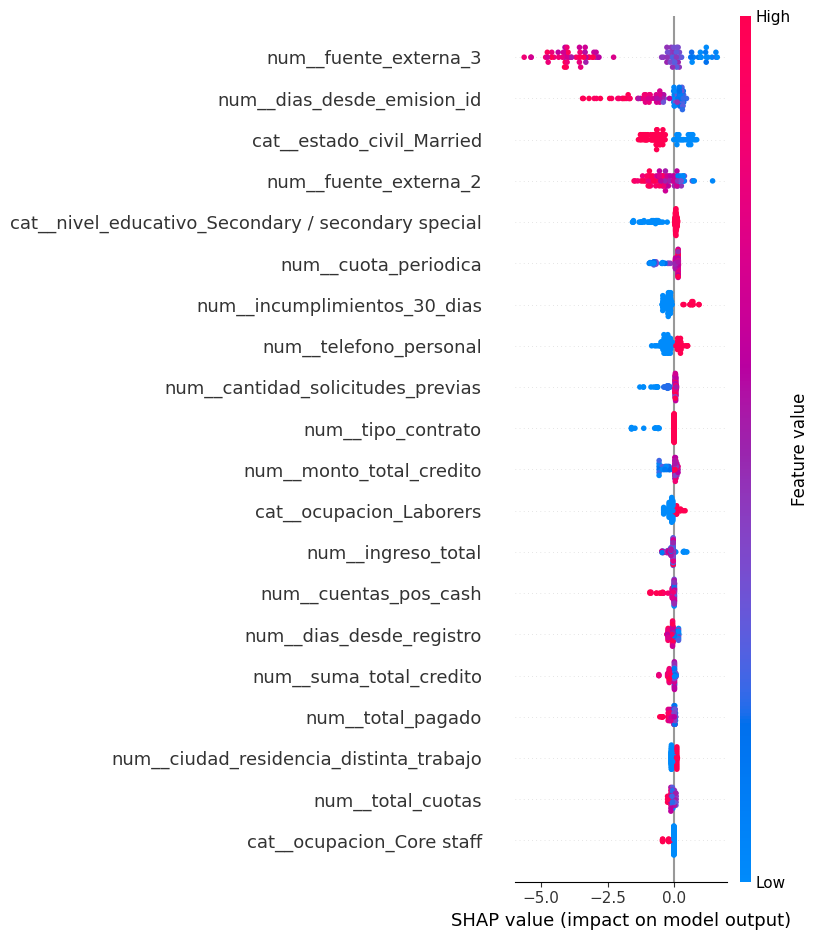

In [17]:
import shap

# Obtener el preprocesamiento y modelo desde el pipeline
model = best_xgb.named_steps["clf"]
X_test_proc = best_xgb.named_steps["preproc"].transform(X_test)

# Obtener nombres de variables transformadas
feature_names = best_xgb.named_steps["preproc"].get_feature_names_out()

# Aplicar SHAP
explainer = shap.Explainer(model)
shap_vals = explainer(X_test_proc)

# Mostrar gráfico con nombres reales
shap.summary_plot(shap_vals, features=X_test_proc, feature_names=feature_names)


# SECCIÓN 5: Guardar modelo ensamblado final

In [ ]:
import os
import joblib

# Crear carpeta
os.makedirs("modelos", exist_ok=True)

# Guardar el modelo ensamblado
joblib.dump(stack, "modelos/ensemble_final.joblib")

# (Opcional) Para cargar más adelante:
# loaded_model = joblib.load("modelos/ensemble_final.joblib")


['modelos/ensemble_final.joblib']

In [20]:
import os
print("📌 Directorio actual:", os.getcwd())

📌 Directorio actual: c:\Users\DELL\Desktop\Aprendizaje_de_Maquina\jbook_Proyecto_Final_Clasificacion\docs2
